# Model Development for Real-Time Drone Sound Detection

This notebook focuses on building and evaluating models for classifying drone vs. non-drone sounds. It begins by loading pre-extracted and preprocessed audio features from the `audio_features.npz` file, a compressed NumPy archive generated during the feature extraction phase. The features are scaled and split into training and testing sets for model training and evaluation.

Several classical machine learning models are then trained and tested, including:

- **K-Nearest Neighbors** 
- **Logistic Regression**  
- **Support Vector Machine (SVM)**  
- **Random Forest**   
- **XGBoost**  

After evaluating these traditional classifiers, a **Convolutional Neural Network (CNN)** is implemented using PyTorch to capture spatial patterns in the MFCC-based audio features. Each model’s performance is analyzed using classification reports, helping to identify the most effective method for real-time drone sound detection.


In [2]:
# Importing Required Libraries

# Numerical operations
import numpy as np

import pandas as pd

# PyTorch for deep learning
import torch                                 
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimizers
from torch.utils.data import DataLoader, TensorDataset, random_split  # Data handling utilities

# For evaluating model predictions
from sklearn.metrics import classification_report

# For data visualization
import matplotlib.pyplot as plt

# For splitting data into train and test sets
from sklearn.model_selection import train_test_split

# For scaling features
from sklearn.preprocessing import StandardScaler

# For various machine learning models and evaluations
from sklearn.metrics import classification_report  # To evaluate model predictions
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors classifier
from sklearn.linear_model import LogisticRegression  # Logistic Regression classifier
from sklearn.model_selection import GridSearchCV  # For hyperparameter tuning
from sklearn.svm import SVC  # Support Vector Machine (SVM) classifier
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier
from xgboost import XGBClassifier  # XGBoost classifier

# For suppressing warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading preprocessed audio features and labels from the compressed .npz file
data = np.load("../feature_extraction/audio_features.npz", allow_pickle=True)
X = data['X']  # Feature matrix (e.g., MFCCs or spectrogram-based features)
y = data['y']  # Corresponding labels (e.g., 0 for non-drone, 1 for drone)

In [4]:
# Flattening the data
X_flat = X.reshape(X.shape[0], -1)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## K-Nearest Neighbors (KNN)

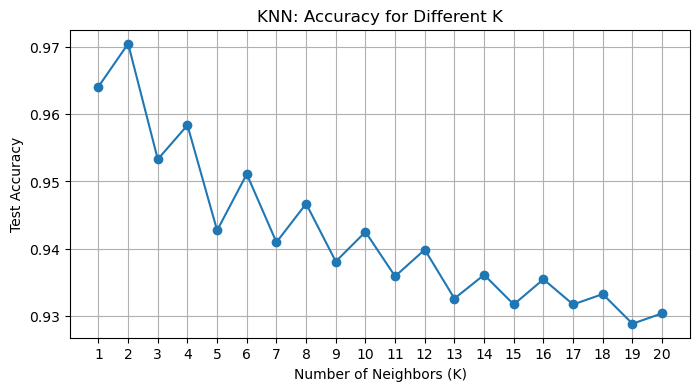

Best K = 2, Test Accuracy = 0.9705


In [6]:
# Finding the best K by sweeping from 1 to 20
k_range = range(1, 21)
scores  = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

# Plotting accuracy vs. number of neighbors (K)
plt.figure(figsize=(8, 4))
plt.plot(k_range, scores, marker='o')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Test Accuracy')
plt.title('KNN: Accuracy for Different K')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Selecting the K with highest test accuracy
best_k = k_range[np.argmax(scores)]
best_acc = max(scores)
print(f"Best K = {best_k}, Test Accuracy = {best_acc:.4f}")

In [7]:
# Retraining KNN using the optimal K
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)
y_pred_knn   = knn_best.predict(X_test_scaled)

# Generating a detailed classification report
print("\nKNN Report with Best K:")
print(classification_report(y_test, y_pred_knn))


KNN Report with Best K:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2320
           1       0.95      1.00      0.97      2219

    accuracy                           0.97      4539
   macro avg       0.97      0.97      0.97      4539
weighted avg       0.97      0.97      0.97      4539



In [8]:
# Generating the classification report for the KNN model as a dictionary for further processing
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)

## Logistic Regression

In [10]:
# Setting the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
}

# Setting up GridSearchCV
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Training with GridSearch
grid_search.fit(X_train_scaled, y_train)

# Best parameters found by GridSearch
print("Best parameters found: ", grid_search.best_params_)

# Getting the best estimator and making predictions
best_lr = grid_search.best_estimator_
y_pred_lr = best_lr.predict(X_test_scaled)

# Testing and evaluating
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))

Best parameters found:  {'C': 0.01}
Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      2320
           1       0.89      0.89      0.89      2219

    accuracy                           0.89      4539
   macro avg       0.89      0.89      0.89      4539
weighted avg       0.89      0.89      0.89      4539



In [11]:
# Generating the classification report for the Logistic Regression model as a dictionary for further processing
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)

## Support Vector Machine (SVM)

In [13]:
# Training SVM
svm = SVC(kernel='rbf', C=1)
svm.fit(X_train_scaled, y_train)

# Testing and evaluating
y_pred_svm = svm.predict(X_test_scaled)
print("SVM Report:\n", classification_report(y_test, y_pred_svm))

SVM Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      2320
           1       0.96      0.98      0.97      2219

    accuracy                           0.97      4539
   macro avg       0.97      0.97      0.97      4539
weighted avg       0.97      0.97      0.97      4539



In [14]:
# Generating the classification report for the Support Vector Machine (SVM) model as a dictionary for further processing
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)

## Random Forest

In [16]:
# Training Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Testing and evaluating
y_pred_rf = rf.predict(X_test_scaled)
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2320
           1       0.98      0.98      0.98      2219

    accuracy                           0.98      4539
   macro avg       0.98      0.98      0.98      4539
weighted avg       0.98      0.98      0.98      4539



In [17]:
# Generating the classification report for the Random Forest model as a dictionary for further processing
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

## XGBoost

In [19]:
# Training XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)

# Testing and evaluating
y_pred_xgb = xgb.predict(X_test_scaled)
print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      2320
           1       0.97      0.99      0.98      2219

    accuracy                           0.98      4539
   macro avg       0.98      0.98      0.98      4539
weighted avg       0.98      0.98      0.98      4539



In [20]:
# Generating the classification report for the XGBoost model as a dictionary for further processing
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)

## Convolutional Neural Network

In [22]:
# Padding all MFCC feature sequences to the same length for batching
N_MFCC = 13  # Number of MFCC features
max_len = 32  # Maximum number of time steps per input sample
X_padded = np.zeros((len(X), max_len, N_MFCC))

# Padding each feature sequence with zeros if it's shorter than max_len
for i, feat in enumerate(X):
    X_padded[i, :feat.shape[0], :] = feat  # Truncating if longer

# Converting features and labels to PyTorch tensors
X_tensor = torch.tensor(X_padded, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [23]:
# Creating a PyTorch Dataset and splitting into training and testing sets
dataset = TensorDataset(X_tensor, y_tensor)

# Splitting 80% for training and 20% for testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating DataLoaders for efficient batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [24]:
# Defining a Convolutional Neural Network for audio classification
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        # 2D convolution with 16 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))  # 2x2 max pooling

        # Calculating flattened dimension after conv + pooling
        conv_output_height = (max_len - 4) // 2
        conv_output_width = (N_MFCC - 4) // 2
        self.fc1 = nn.Linear(16 * conv_output_height * conv_output_width, 64)  # Fully connected layer
        self.fc2 = nn.Linear(64, 2)  # Output layer (2 classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Adding channel dimension for Conv2D
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flattening for fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
# Setting up device, model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AudioCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
# Training the model
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Clearing gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Computing loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimizer update

        running_loss += loss.item()

    # Logging average loss for this epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.2719
Epoch 2, Loss: 0.1494
Epoch 3, Loss: 0.1211
Epoch 4, Loss: 0.1088
Epoch 5, Loss: 0.0917
Epoch 6, Loss: 0.0849
Epoch 7, Loss: 0.0757
Epoch 8, Loss: 0.0709
Epoch 9, Loss: 0.0667
Epoch 10, Loss: 0.0644


In [27]:
# Switching model to evaluation mode (disables dropout, gradient tracking, etc.)
model.eval()

all_preds = []
all_labels = []

# Running inference on the test set without gradient computation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Getting class with highest score
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [28]:
# Printing classification metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Non-Drone", "Drone"]))


Classification Report:
              precision    recall  f1-score   support

   Non-Drone       0.98      0.96      0.97      2332
       Drone       0.96      0.98      0.97      2207

    accuracy                           0.97      4539
   macro avg       0.97      0.97      0.97      4539
weighted avg       0.97      0.97      0.97      4539



In [29]:
# Generating the classification report for the CNN model as a dictionary for further processing
report_cnn = classification_report(all_labels, all_preds, target_names=["Non-Drone", "Drone"], output_dict=True)

## Summary Table

In [31]:
summary_data = {
    'KNN': {
        'accuracy': report_knn['accuracy'],
        'f1-score': report_knn['macro avg']['f1-score']
    },
    'Logistic Regression': {
        'accuracy': report_lr['accuracy'],
        'f1-score': report_lr['macro avg']['f1-score']
    },
    'SVM': {
        'accuracy': report_svm['accuracy'],
        'f1-score': report_svm['macro avg']['f1-score']
    },
    'Random Forest': {
        'accuracy': report_rf['accuracy'],
        'f1-score': report_rf['macro avg']['f1-score']
    },
    'XGBoost': {
        'accuracy': report_xgb['accuracy'],
        'f1-score': report_xgb['macro avg']['f1-score']
    },
    'CNN': {
        'accuracy': report_cnn['accuracy'],
        'f1-score': report_cnn['macro avg']['f1-score']
    }
}

# Converting to DataFrame
classification_summary = pd.DataFrame(summary_data).transpose()

# Renaming columns
classification_summary.rename(columns={'accuracy': 'Accuracy', 'f1-score': 'F1-Score'}, inplace=True)
classification_summary.index.name = 'Models'
classification_summary.columns = pd.MultiIndex.from_tuples([('Metrics', col) for col in classification_summary.columns])

# Saving as CSV
classification_summary.to_csv('../results/tables/classification_summary.csv')

# Exporting to LaTeX
latex_code = classification_summary.to_latex(float_format='%.2f', multirow=True)
latex_code = latex_code.replace(r'\multicolumn{2}{l}{Metrics}', r'\multicolumn{2}{c}{Metrics}')

with open('../results/tables/classification_summary.tex', 'w') as f:
    f.write(latex_code)

In [32]:
# Printing the classification summary table
classification_summary

Metrics          
                     Accuracy  F1-Score
Models                                 
KNN                  0.970478  0.970478
Logistic Regression  0.888962  0.888914
SVM                  0.969817  0.969809
Random Forest        0.979731  0.979723
XGBoost              0.982595  0.982592
CNN                  0.970919  0.970908

## Model Saving and Download

In [34]:
# Saving the model weights to a .pth file
torch.save(model.state_dict(), "audio_cnn_weights.pth")